#⏩Phase I : MDP & Policy Iteration

##🔹MDP environment functions

In [ ]:
import numpy as np
import pandas as pd
import itertools

def make_environment(N : int, price_range : list):
  # H and L init_state rewards for each stock
  rewards = np.zeros((N, 2))
  for row in rewards:
    row[0] = np.round(np.random.uniform(price_range[0], price_range[-1]), 4)
    row[1] = np.round(np.random.uniform(row[0], price_range[-1]), 4)

  # transition probabilities for each stock
  probabilities = np.zeros((N, 4))
  for row in probabilities:
    for i in range(0, 3, 2):
      row[i] = np.round(np.random.uniform(0,1), 4)
      row[i+1] = 1 - row[i]

  # initial state
  init_state = np.zeros((N+1,))
  for index, _ in enumerate(init_state):
    init_state[index] = np.random.choice([0,1])
  init_state[0] = np.random.choice(np.arange(N))
  return rewards, probabilities, init_state


def generate_possible_states(N : int):
  '''Generates a (N*(2**N), N+1) array with rows representing all possible states'''
  possible_states = np.empty((0, N + 1))
  for action in range(N):
    for x in itertools.product([0,1], repeat=N):
      combination = list(x)
      combination.insert(0, action)
      possible_states = np.vstack((possible_states, combination))
  return possible_states


def make_next_state(current_state, action, trans_prob):
  '''Generates a new state using the given transition probabilities'''
  if action not in range(N):
    raise ValueError("Action out of range!")

  next_state = np.zeros_like(current_state)
  next_state[0] = action    # which stock we are holding
  for i, value in enumerate(next_state):
    if i == 0: continue
    if current_state[i] == 1:
      next_state[i] = np.random.choice([1,0], p=trans_prob[i-1, :2])
    else:
      next_state[i] = np.random.choice([0,1], p=trans_prob[i-1, 2:])
  return next_state


def eval_total_transition_P(current_state, next_state, trans_prob):
  '''Returns the total probability of transitioning from a state to another'''
  probability = 1
  for i, value in enumerate(next_state):
    if i == 0: continue
    if current_state[i] == 1:
      if next_state[i] == 1:
        probability *= trans_prob[i-1, 0]
      else:
        probability *= trans_prob[i-1, 1]
    else:
      if next_state[i] == 1:
        probability *= trans_prob[i-1, 3]
      else:
        probability *= trans_prob[i-1, 2]
  return round(probability, 7)


def eval_expected_reward(current_state, action, trans_prob, immediate_rewards, transaction_fee=0.01):
  '''Returns the expected reward of taking action a given state s'''
  if action not in range(N):
    raise ValueError("Action out of range!")

  current_stock = int(current_state[0])
  next_stock = action   # will determine if transaction fee is payed
  if current_state[next_stock + 1] == 0:    # if in state "L"
    expected_reward = trans_prob[next_stock, 2] * immediate_rewards[next_stock, 0]\
                      + trans_prob[next_stock, 3] * immediate_rewards[next_stock, 1]
  else:   # if in state "H"
    expected_reward = trans_prob[next_stock, 0] * immediate_rewards[next_stock, 1]\
                      + trans_prob[next_stock, 1] * immediate_rewards[next_stock, 0]

  if next_stock != current_stock:   # pay fee
    expected_reward -= transaction_fee
  return round(expected_reward, 7)


def eval_reward(current_state, next_state, immediate_rewards, transaction_fee):
  '''Returns the true reward when transitioning from a state to another'''
  current_stock = int(current_state[0])
  next_stock = int(next_state[0])   # will determine if transaction fee is payed
  next_stock_state = int(next_state[next_stock + 1])   # tells if the new stock is in state "L" or "H"
  reward = immediate_rewards[next_stock, next_stock_state]
  if next_stock != current_stock:   # pay fee
    reward -= transaction_fee
  return round(reward, 7)

##🔹Policy iteration

In [ ]:
def evaluate_policy(policy, states, trans_prob, immediate_rewards, fee, gamma, epsilon=1e-07):
  '''Returns a vector with the value of each state under the given policy'''
  prev_V = np.zeros((len(states)))
  while True:
    V = np.zeros((len(states)))
    for i, state in enumerate(states):
      action = policy[i]
      for j, next_state in enumerate(states):
        if action != next_state[0]: continue    # only iterate over states with same action (possible transitions)
        V[i] += eval_total_transition_P(state, next_state, trans_prob)\
                 * (eval_reward(state, next_state, immediate_rewards, fee) + gamma * prev_V[j])
    if np.max(np.abs(prev_V - V)) < epsilon:
      break
    prev_V = V.copy()
    # print(V)
  V = np.round(V, 7)
  return V


def improve_policy(V, states, trans_prob, immediate_rewards, fee, gamma):
  '''Returns a better policy given a state-value function and the model'''
  actions = int((states.shape[1]) - 1)
  Q = np.zeros((len(states), actions))    # action-value function with the 2 possible actions for each state
  for i, state in enumerate(states):
    for action in range(actions):
      for j, next_state in enumerate(states):
        if action != next_state[0]: continue
        Q[i, action] += eval_total_transition_P(state, next_state, trans_prob)\
                       * (eval_reward(state, next_state, immediate_rewards, fee) + gamma * V[j])
    # print(Q)
  new_policy = np.argmax(Q, axis=1)
  return new_policy


def policy_iteration(states, trans_prob, immediate_rewards, fee, gamma):
  '''Alternates between evaluation and improvement to find the optimal policy'''
  # policy = np.random.choice([0, 1], size=len(possible_states))
  policy = np.random.randint(0, N, size=len(possible_states))
  t = 0   # number of policy improvements
  while True:
    V = evaluate_policy(policy, states, trans_prob, immediate_rewards, fee, gamma)
    improved_policy = improve_policy(V, states, trans_prob, immediate_rewards, fee, gamma)
    if np.all(policy == improved_policy):   # convergence check
      break
    t += 1
    # print(f"{policy} ---> {improved_policy}")
    policy = improved_policy

  optimal_policy = policy
  return optimal_policy, t

In [ ]:
# optimal_policy, t = policy_iteration(possible_states, probabilities, rewards, fee=0.01, gamma=0.9)
# print(f"The optimal policy is: {optimal_policy}")
# print(f"Iterations for convergence: {t}")

In [ ]:
N = 4
np.random.randint(0, N, size=N)

array([0, 2, 3, 3])

###Questions 1 & 2 (small scale)

In [ ]:
possible_states = generate_possible_states(N=2)

print("Possible states")
for i, row in enumerate(possible_states):
  print(f"S_{i}:  {row}")

Possible states
S_0:  [0. 0. 0.]
S_1:  [0. 0. 1.]
S_2:  [0. 1. 0.]
S_3:  [0. 1. 1.]
S_4:  [1. 0. 0.]
S_5:  [1. 0. 1.]
S_6:  [1. 1. 0.]
S_7:  [1. 1. 1.]


* Scenario 1 (always stay)

In [ ]:
np.random.seed(42)

N = 2
rewards, probabilities, init_state = make_environment(N, [-0.15, 0.15])

# environment parameters
rewards[0, 1] = 2 * rewards[1, 1]
fee = 0.13
gamma = 0

possible_states = generate_possible_states(N)
rewards_df = pd.DataFrame(rewards, columns=['L', 'H'])
probabilities_df = pd.DataFrame(probabilities, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])


print(17*'--')
print("Immediate rewards")
print(rewards_df)
print(f"(Transaction fee = {100*fee:.0f}%)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)


optimal_policy, t = policy_iteration(possible_states, probabilities, rewards, fee, gamma)
print(f"The optimal policy is: {optimal_policy}")
print(f"Iterations for convergence: {t}")

----------------------------------
Immediate rewards
        L       H
0 -0.0376  0.2354
1  0.0696  0.1177
(Transaction fee = 13%)
----------------------------------
Transition probabilities
     p_HH    p_HL    p_LL    p_LH
0  0.1560  0.8440  0.1560  0.8440
1  0.0581  0.9419  0.8662  0.1338
The optimal policy is: [0 0 0 0 1 1 1 1]
Iterations for convergence: 1


* Scenario 2 (switch in some states)

In [ ]:
np.random.seed(42)

N = 2
rewards, probabilities, init_state = make_environment(N, [-0.15, 0.15])

# environment parameters
rewards[0, 1] = 2 * rewards[1, 1]
fee = 0.01
gamma = 0.9

possible_states = generate_possible_states(N)
rewards_df = pd.DataFrame(rewards, columns=['L', 'H'])
probabilities_df = pd.DataFrame(probabilities, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])


print(17*'--')
print("Immediate rewards")
print(rewards_df)
print(f"(Transaction fee = {100*fee:.0f}%)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)


optimal_policy, t = policy_iteration(possible_states, probabilities, rewards, fee, gamma)
print(f"The optimal policy is: {optimal_policy}")
print(f"Iterations for convergence: {t}")

----------------------------------
Immediate rewards
        L       H
0 -0.0376  0.2354
1  0.0696  0.1177
(Transaction fee = 1%)
----------------------------------
Transition probabilities
     p_HH    p_HL    p_LL    p_LH
0  0.1560  0.8440  0.1560  0.8440
1  0.0581  0.9419  0.8662  0.1338
The optimal policy is: [0 0 1 1 0 0 1 1]
Iterations for convergence: 1


In [ ]:
# check if this is indeed the optimal policy
curr = possible_states[2]
good = eval_expected_reward(curr, 1, probabilities, rewards)
bad = eval_expected_reward(curr, 0, probabilities, rewards)
print(f'good is {good:.3f}, bad is {bad:.3f}')

good is 0.066, bad is 0.005


###Question 3 (larger scale)

In [ ]:
np.random.seed(42)

N = 7
rewards, probabilities, init_state = make_environment(N, [-0.02, 0.1])
h = N // 2
for i, row in enumerate(probabilities):
  if i <= h:
    probabilities[i] = [0.9, 0.1, 0.9, 0.1]
  else:
    probabilities[i] = [0.5, 0.5, 0.5, 0.5]

possible_states = generate_possible_states(N)

rewards_df = pd.DataFrame(rewards, columns=['L', 'H'])
probabilities_df = pd.DataFrame(probabilities, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])

print(17*'--')
print("Immediate rewards")
print(rewards_df)
print("(Transaction fee = 0.01)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)
print(17*'--')
print(f"Number of states = {possible_states.shape[0]}")

----------------------------------
Immediate rewards
        L       H
0  0.0249  0.0963
1  0.0678  0.0871
2 -0.0013  0.0145
3 -0.0130  0.0849
4  0.0521  0.0860
5 -0.0175  0.0965
6  0.0799  0.0842
(Transaction fee = 0.01)
----------------------------------
Transition probabilities
   p_HH  p_HL  p_LL  p_LH
0   0.9   0.1   0.9   0.1
1   0.9   0.1   0.9   0.1
2   0.9   0.1   0.9   0.1
3   0.9   0.1   0.9   0.1
4   0.5   0.5   0.5   0.5
5   0.5   0.5   0.5   0.5
6   0.5   0.5   0.5   0.5
----------------------------------
Number of states = 896


In [ ]:
import time
start = time.time()
np.random.seed(42)

fee = 0.01
gamma = 0.9

policy_large, t = policy_iteration(possible_states, probabilities, rewards, fee, gamma)
print(f"The optimal policy is: {policy_large}")
print(f"Iterations for convergence: {t}")

end = time.time()
time = end - start
print(f"Time: {round(time, 2)}s")

In [ ]:
# policy of PI for N=7 terminated in 27m
PI_result = '6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1\
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1\
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1\
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1\
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1\
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1\
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0'

number_strings = PI_result.split()
numbers_list = [int(num) for num in number_strings]
policy_large = np.array(numbers_list)

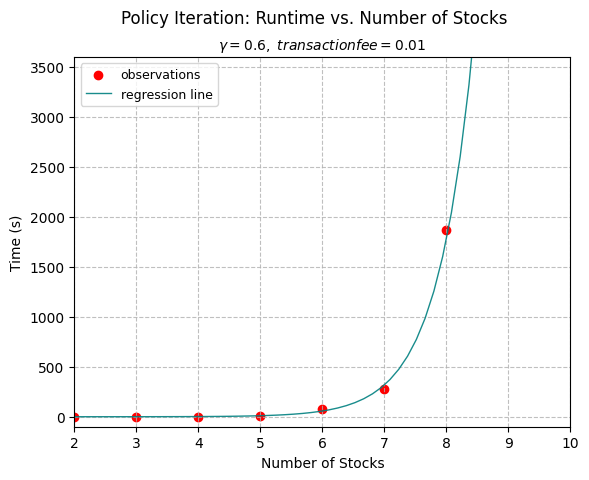

Mean Squared Error: 1402.12


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# data points
stocks = np.array([2, 3, 4, 5, 6, 7, 8])
times = np.array([0.07, 0.34, 1.22, 10.86, 72.96, 281.09, 1868.51])

# reshaping into column for use in sklearn
stocks = stocks.reshape(-1, 1)

# transform the times data using the natural logarithm
log_times = np.log(times)

# fit a linear regression model to the transformed data
model = LinearRegression()
model.fit(stocks, log_times)

# generate x values for the trend line
x = np.linspace(2, 16, 100).reshape(-1, 1)

# predict the log-transformed y values
log_y_pred = model.predict(x)

# transform the predictions back to the original scale
y_pred = np.exp(log_y_pred)

plt.scatter(stocks, times, color='red', label='observations')
plt.plot(x, y_pred, color='teal', label='regression line', linewidth=1, alpha=0.9)
plt.xlabel('Number of Stocks')
plt.ylabel('Time (s)')
plt.suptitle('Policy Iteration: Runtime vs. Number of Stocks', fontsize=12)
plt.title(r'$\gamma=0.6,\ transaction fee=0.01$', fontsize=10)
plt.legend(fontsize='9')
plt.grid(True, linestyle='--', alpha=0.8)
plt.ylim(-100, 3600)
plt.xlim(2, 10)
plt.show()

# evaluate the model
y_pred_train = np.exp(model.predict(stocks))
mse = mean_squared_error(times, y_pred_train)
print(f'Mean Squared Error: {mse:.2f}')

In [ ]:
def predict_runtime(N):
    log_time_pred = model.predict(np.array([[N]]))
    time_pred = np.exp(log_time_pred)
    return time_pred[0]

# predict the target for N = 10
N = 9
predicted_time = predict_runtime(N)
print(f'Predicted time for {N} stocks: {predicted_time:.2f} seconds')

#⏩Phase II : RL & Deep-RL

##🔹Q-learning

In [ ]:
def initialize_Q_table(num_states, actions):
  return np.zeros((num_states, actions))


def decide_action(state_index, Q_table, epsilon, actions):
    '''e-Greedy action selection'''
    if np.random.rand() < epsilon:
        # explore: choose a random action
        action = np.random.randint(actions)
    else:
        # exploit: choose the action with the highest Q-value for the current state
        action = np.argmax(Q_table[state_index])
    return action


def deploy_Q_learning(states, actions, R, P, fee, num_episodes, horizon, gamma, alpha, epsilon, decay_rate):
    '''Main algorithm for learning the Q table'''
    Q_table = initialize_Q_table(len(states), actions)

    for episode in range(num_episodes):
        state_index = int(np.random.choice(len(states)))
        state = states[state_index]  # pick an initial state
        # print(f'\nEPISODE {episode}')

        for step in range(horizon):
            action = decide_action(state_index, Q_table, epsilon, actions)
            next_state = make_next_state(state, action, P)
            reward = eval_reward(state, next_state, R, fee)
            # print(f'Starting from {state}, action {action} gets us to {next_state} with reward {reward}')

            # Q-learning update
            best_action = np.argmax(Q_table[state_index])
            td_target = reward + gamma * Q_table[state_index, best_action]
            td_error = td_target - Q_table[state_index, action]
            Q_table[state_index, action] += alpha * td_error
            state = next_state
            state_index = int(np.where((states == next_state).all(axis=1))[0][0])

        # reduce exploration over time
        epsilon *= decay_rate
    return Q_table


def extract_optimal_policy(Q_table):
    num_states = int(Q_table.shape[0])
    actions = int(Q_table.shape[1])
    policy = np.zeros((num_states), dtype=int)
    for state_index in range(num_states):
        best_action = np.argmax(Q_table[state_index])
        policy[state_index] = best_action
    return policy

###Task 1 (small scale)

* Scenario 1 (always stay)

In [ ]:
np.random.seed(42)

N = 2
R, P, init_state = make_environment(N, [-0.15, 0.15])

# environment parameters
R[0, 1] = 2 * R[1, 1]
fee = 0.13
gamma = 0

possible_states = generate_possible_states(N)
rewards_df = pd.DataFrame(R, columns=['L', 'H'])
probabilities_df = pd.DataFrame(P, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])


print(17*'--')
print("Immediate rewards")
print(rewards_df)
print(f"(Transaction fee = {100*fee:.0f}%)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)

----------------------------------
Immediate rewards
        L       H
0 -0.0376  0.2354
1  0.0696  0.1177
(Transaction fee = 13%)
----------------------------------
Transition probabilities
     p_HH    p_HL    p_LL    p_LH
0  0.1560  0.8440  0.1560  0.8440
1  0.0581  0.9419  0.8662  0.1338


In [ ]:
import time
start = time.time()

# Q-learning parameters
episodes = 100
horizon = 100
alpha = 0.1
epsilon = 1
decay_rate = 0.9

Q_table = deploy_Q_learning(possible_states, N, R, P, fee, episodes, horizon, gamma, alpha, epsilon, decay_rate)
optimal_policy = extract_optimal_policy(Q_table)

end = time.time()
time = end - start

print("Q-learning results")
print(20*'--')
print(f"The optimal policy is: {optimal_policy}")
print(f"Runtime: {round(time, 2)}s")

Q-learning results
----------------------------------------
The optimal policy is: [0 0 0 0 1 1 1 1]
Runtime: 1.14s


* Scenario 2 (switch in some states)

In [ ]:
np.random.seed(42)

N = 2
R, P, init_state = make_environment(N, [-0.15, 0.15])

# environment parameters
R[0, 1] = 2 * R[1, 1]
fee = 0.01
gamma = 0.9

possible_states = generate_possible_states(N)
rewards_df = pd.DataFrame(R, columns=['L', 'H'])
probabilities_df = pd.DataFrame(P, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])


print(17*'--')
print("Immediate rewards")
print(rewards_df)
print(f"(Transaction fee = {100*fee:.0f}%)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)

----------------------------------
Immediate rewards
        L       H
0 -0.0376  0.2354
1  0.0696  0.1177
(Transaction fee = 1%)
----------------------------------
Transition probabilities
     p_HH    p_HL    p_LL    p_LH
0  0.1560  0.8440  0.1560  0.8440
1  0.0581  0.9419  0.8662  0.1338


In [ ]:
import time
start = time.time()

# Q-learning parameters
episodes = 100
horizon = 100
alpha = 0.1
epsilon = 1
decay_rate = 0.9

Q_table = deploy_Q_learning(possible_states, N, R, P, fee, episodes, horizon, gamma, alpha, epsilon, decay_rate)
optimal_policy = extract_optimal_policy(Q_table)

end = time.time()
time = end - start

print("Q-learning results")
print(20*'--')
print(f"The optimal policy is: {optimal_policy}")
print(f"Runtime: {round(time, 2)}s")

Q-learning results
----------------------------------------
The optimal policy is: [0 0 1 1 0 0 1 1]
Runtime: 1.1s


###Task 2 (larger scale)

In [ ]:
np.random.seed(42)

# environment parameters
N = 7
R, P, _ = make_environment(N, [-0.02, 0.1])
h = N // 2
for i, row in enumerate(P):
  if i <= h:
    P[i] = [0.9, 0.1, 0.9, 0.1]
  else:
    P[i] = [0.5, 0.5, 0.5, 0.5]

fee = 0.01
gamma = 0.9

possible_states = generate_possible_states(N)
rewards_df = pd.DataFrame(R, columns=['L', 'H'])
probabilities_df = pd.DataFrame(P, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])

print(17*'--')
print("Immediate rewards")
print(rewards_df)
print(f"(Transaction fee = {100*fee:.0f}%)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)
print(17*'--')
print(f"Number of states = {possible_states.shape[0]}")

----------------------------------
Immediate rewards
        L       H
0  0.0249  0.0963
1  0.0678  0.0871
2 -0.0013  0.0145
3 -0.0130  0.0849
4  0.0521  0.0860
5 -0.0175  0.0965
6  0.0799  0.0842
(Transaction fee = 1%)
----------------------------------
Transition probabilities
   p_HH  p_HL  p_LL  p_LH
0   0.9   0.1   0.9   0.1
1   0.9   0.1   0.9   0.1
2   0.9   0.1   0.9   0.1
3   0.9   0.1   0.9   0.1
4   0.5   0.5   0.5   0.5
5   0.5   0.5   0.5   0.5
6   0.5   0.5   0.5   0.5
----------------------------------
Number of states = 896


In [ ]:
import time
start = time.time()
np.random.seed(42)

# Q-learning parameters
episodes = 100
horizon = 10000
alpha = 0.1
epsilon = 1
decay_rate = 0.9

Q_table = deploy_Q_learning(possible_states, N, R, P, fee, episodes, horizon, gamma, alpha, epsilon, decay_rate)
policy_large_Q = extract_optimal_policy(Q_table)

end = time.time()
time = end - start

print("Q-learning results")
print(20*'--')
print(f"The optimal policy is: {policy_large_Q}")
print(f"Runtime: {round(time, 2)}s")

Q-learning results
----------------------------------------
The optimal policy is: [4 4 1 6 1 4 6 6 6 3 3 3 6 6 6 1 1 0 4 6 1 4 6 6 3 4 3 1 3 6 6 6 4 1 1 1 6
 1 1 6 6 6 6 6 3 1 1 6 1 1 4 6 1 1 6 6 3 6 1 4 6 3 1 6 4 0 6 1 0 0 4 1 3 4
 0 0 3 0 3 6 6 1 6 0 1 1 4 1 0 6 0 3 6 6 1 6 1 0 6 1 1 0 4 0 1 1 3 6 1 3 3
 1 0 0 0 0 0 0 1 1 1 0 6 0 1 4 0 3 1 1 6 1 4 1 6 4 6 3 4 4 3 6 6 4 6 4 5 1
 1 1 4 6 4 1 4 6 3 1 4 6 1 1 1 6 1 1 6 6 1 3 6 6 1 1 3 6 4 6 6 1 6 4 6 4 6
 6 1 1 1 1 1 6 6 0 1 0 6 6 6 0 1 1 0 3 1 6 1 6 4 0 0 0 6 0 0 0 0 4 1 6 3 3
 3 6 1 0 4 1 0 4 6 0 3 1 1 0 1 3 4 4 1 1 1 0 4 6 1 0 4 1 3 1 0 1 1 1 4 6 1
 6 4 6 6 6 6 6 6 4 6 1 4 3 1 4 6 6 6 6 4 6 6 6 1 1 1 4 6 4 6 4 1 1 6 6 4 4
 3 6 1 1 1 3 3 3 4 6 6 6 1 4 1 1 4 4 4 6 1 1 1 3 0 6 6 1 1 1 6 1 4 4 6 0 6
 0 6 0 0 0 4 6 6 1 6 6 0 0 1 0 4 0 4 6 6 1 1 1 0 1 0 6 4 6 6 6 6 4 1 6 1 1
 0 1 6 4 6 1 6 0 0 0 1 1 0 0 6 6 6 6 6 6 1 6 3 6 3 4 3 4 6 6 6 6 4 1 5 6 1
 1 3 4 3 6 6 1 1 3 1 4 4 1 4 6 5 4 1 1 3 3 6 3 4 1 1 1 1 1 6 1 6 1 6 4 3 4
 1 6 6 1 6 6 0 6 

In [ ]:
# policy of Q-learning for N=7 and (episodes, horizon) = (100, 100000) terminated in 46m
Q_result = '6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 6 1 6\
 1 1 6 1 1 6 1 1 1 6 6 1 1 1 1 6 6 1 1 6 1 6 6 6 1 6 1 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 1 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1\
 1 1 1 1 1 1 1 0 0 4 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 0 6 6 0 0 0\
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6\
 1 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 3 3 1 6 6 4 1 6 6 6 1 1 6\
 6 6 6 6 1 3 6 6 1 1 6 1 6 6 6 1 3 6 6 6 1 1 1 1 0 6 0 0 0 0 6 0 0 0 6 0 0\
 0 0 6 6 6 6 6 0 1 0 6 0 0 0 6 0 0 6 6 0 0 6 0 6 0 0 0 0 1 6 1 1 0 1 1 6 0\
 1 1 0 0 0 0 0 0 0 6 1 1 0 1 6 6 6 6 6 6 6 6 6 3 3 4 6 6 6 6 1 6 6 6 6 6 6\
 6 3 6 6 6 6 6 3 6 1 1 1 6 1 6 1 1 1 1 1 1 6 6 1 1 6 1 1 6 1 6 6 1 1 3 6 1\
 1 1 6 1 0 0 0 0 6 6 6 0 0 0 0 6 6 0 3 0 6 0 6 6 0 6 0 6 6 6 0 0 3 0 0 0 1\
 1 1 1 6 1 6 6 0 6 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 3 6 6 6 6 6 1 1 1 1 6 1 1 6 4 6 1\
 1 6 6 1 1 1 6 1 6 6 6 1 1 1 6 6 6 6 1 1 4 0 0 0 6 0 0 0 0 0 0 0 6 6 6 0 6\
 0 6 6 0 0 0 0 0 0 0 6 0 0 6 0 0 0 0 0 4 0 0 0 1 4 0 1 0 0 1 0 4 0 0 0 0 1\
 0 0 0 1 0 6 4 1 0 0 0 6 6 6 6 6 6 6 6 4 4 1 6 1 3 1 6 6 6 6 6 6 6 1 6 6 6\
 4 3 6 6 6 6 1 1 1 6 1 6 1 1 1 6 1 1 1 6 1 1 6 1 6 4 1 6 1 1 1 1 1 6 1 6 1\
 1 6 6 0 1 6 0 6 0 0 6 6 6 6 6 6 0 0 0 6 1 0 0 0 6 0 0 0 0 6 0 0 6 0 1 1 0\
 0 0 6 1 1 6 0 0 6 6 6 0 1 0 0 0 6 6 1 0 1 1 1 6 0 1 1 3 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6\
 6 6 6 6 6 6 6 6'
number_strings = Q_result.split()
numbers_list = [int(num) for num in number_strings]
policy_large_Q = np.array(numbers_list)

###🔸Q-learning vs. P.I.

* Direct policy comparison (not necessary condition)

In [ ]:
def percent_equal_values(arr1, arr2):
    if len(arr1) != len(arr2):
        raise ValueError("Arrays must be of the same length")
    equal_count = sum(1 for a, b in zip(arr1, arr2) if a == b)
    total_count = len(arr1)
    equal_percentage = (equal_count / total_count) * 100
    return round(equal_percentage)

In [ ]:
# check if the two policies are exactly the same
percent_equal_values(policy_large, policy_large_Q)

65

* Average cumulative reward comparison (sufficient condition)

In [ ]:
def play_policy(policy, states, R, P, fee, N_trials):
  '''Returns the averaged cumulative reward per trial (N_trials elements)'''
  current_state_idx = int(np.random.choice(len(states)))
  current_state = states[current_state_idx]  # pick an initial state
  action = policy[current_state_idx]
  avg_cumul_reward = np.zeros((N_trials,))
  total_reward = 0
  for i in range(N_trials):
    new_state = make_next_state(current_state, action, P)
    reward = eval_reward(current_state, new_state, R, fee)
    total_reward += reward
    avg_cumul_reward[i] = (total_reward) / (i + 1)

    current_state_idx = int(np.where((states == current_state).all(axis=1))[0][0])
    current_state = states[current_state_idx]
    action = policy[current_state_idx]

  # mean = np.mean(avg_cumul_reward)
  return avg_cumul_reward


def run_simulations(policy, states, R, P, fee, N_trials, N_sim):
  '''Returns the cumulative reward per round averaged across N_sim simulations (N_trials elements)'''
  avg_cumul_reward = np.zeros((N_sim, N_trials))
  for sim in range(N_sim):
    avg_cumul_reward[sim] = play_policy(policy, states, R, P, fee, N_trials)

  means = np.mean(avg_cumul_reward, axis=0)
  return means

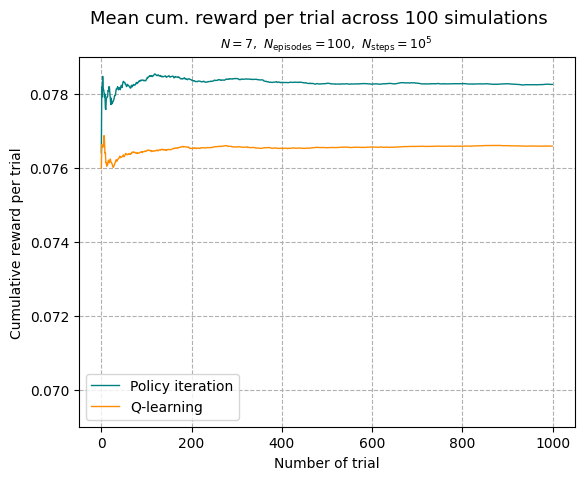

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(42)

N_sim = 100
N_trials = 1000

# run simulations
sims1 = run_simulations(policy_large, possible_states, R, P, 0.01, N_trials, N_sim)
sims2 = run_simulations(policy_large_Q, possible_states, R, P, 0.01, N_trials, N_sim)

# plot results
plt.plot(sims1, color='teal', linewidth=1, label='Policy iteration')
plt.plot(sims2, color='darkorange', linewidth=1, label='Q-learning')

plt.xlabel('Number of trial')
plt.ylabel('Cumulative reward per trial')
plt.suptitle(f'Mean cum. reward per trial across {N_sim} simulations', fontsize=13)
plt.title(r'$N=7,\ N_{\mathrm{episodes}}=100,\ N_{\mathrm{steps}}=10^5$', fontsize=9)
plt.legend()
plt.grid(True, linestyle='--')
plt.ylim((0.069, 0.079))
plt.show()

In [ ]:
diff = sims1[999]-sims2[999]
percent = (sims2[999]/sims1[999])*100
print(f'Q-learning mean cum.reward per trial is {diff:4f} less than P.I.')
print(f'Q-learning mean cum.reward per trial is {percent:.2f}% that of P.I.')

Q-learning mean cum.reward per trial is 0.001670 less than P.I.
Q-learning mean cum.reward per trial is 97.87% that of P.I.


In [ ]:
(policy_large==policy_large_Q).all()

False

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(42)

# compare the above to random policies
N_sim = 10
N_trials = 1000
num_pol = 20
policies_rand = np.zeros((num_pol, N_trials))

for i in range(num_pol):
  rand_policy = np.random.randint(0, N, size=len(possible_states))
  sims_rand = run_simulations(rand_policy, possible_states, rewards, probabilities, 0.01, N_trials, N_sim)
  policies_rand[i] = sims_rand

mean_result = np.repeat(np.mean(policies_rand[:,-1]), N_trials)

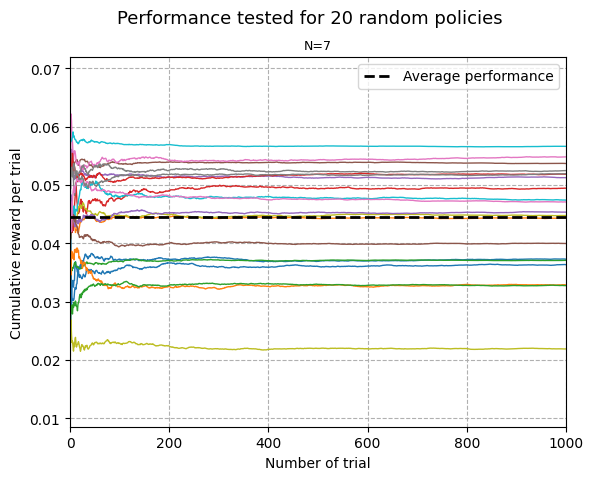

In [ ]:
for i in range(num_pol):
    plt.plot(policies_rand[i], linewidth=1)

plt.plot(mean_result, linewidth=2, linestyle='--', color='black', label="Average performance")
plt.xlabel('Number of trial')
plt.ylabel('Cumulative reward per trial')
plt.suptitle(f'Performance tested for {num_pol} random policies', fontsize=13)
plt.title('N=7', fontsize=9)
plt.legend()
plt.xlim((0,1000))
plt.grid(True, linestyle='--')
plt.show()

##🔹Deep-Q-Network

###DQN environment functions

In [ ]:
def DQN_states(MDP_states, rewards):
  '''Transforms the MPD state space to DQN state space'''
  possible_states = np.empty_like(MDP_states)
  for i, state in enumerate(MDP_states):
    for j, val in enumerate(state):
      if j == 0: continue
      stock_state = int(val)
      possible_states[i, j] = rewards[j-1, stock_state]
  possible_states[:, 0] = MDP_states[:, 0].astype(int)
  return possible_states


def make_next_state(current_state, action, trans_prob):
  '''Generates a new state using the given transition probabilities'''
  if action not in range(N):
    raise ValueError("Action out of range!")

  next_state = np.zeros_like(current_state)
  next_state[0] = action    # which stock we are holding
  for i, value in enumerate(next_state):
    if i == 0: continue
    if current_state[i] == 1:
      next_state[i] = np.random.choice([1,0], p=trans_prob[i-1, :2])
    else:
      next_state[i] = np.random.choice([0,1], p=trans_prob[i-1, 2:])
  return next_state


def MDP_to_DQN(MDP_state, rewards):
  DQN_state = np.zeros_like(MDP_state)
  DQN_state[0] = MDP_state[0]
  for i, val in enumerate(MDP_state):
    if i == 0: continue
    stock_state = int(val)
    DQN_state[i] = rewards[i-1, stock_state]
  return DQN_state

# def DQN_make_state(state, rewards, probabilities):
#   '''Takes as input the current DQN's state and generates a new one based on the P matrix'''
#   next_state = np.zeros_like(state)
#   for i, value in enumerate(next_state):
#     r_L = rewards[i, 0]
#     r_H = rewards[i, 1]
#     if state[i] == 1:
#       next_state[i] = np.random.choice([r_H, r_L], p=probabilities[i, :2])
#     else:
#       next_state[i] = np.random.choice([r_L, r_H], p=probabilities[i, 2:])
#   return next_state


def DQN_reward_func(state, next_state, fee):
    # calculate reward based on the yield of the stock corresponding to action
    previous_action = int(state[0])
    action = int(next_state[0])
    reward = next_state[action + 1]
    if action != previous_action:
      reward -= fee
    return reward

###DQN components

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import random


def create_dqn(state_size, action_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(state_size, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, action_size)
        )
    return model


def add_to_replay_buffer(buffer, buffer_size, experience):
    if len(buffer) >= buffer_size:
        buffer.pop(0)
    buffer.append(experience)


def sample_from_replay_buffer(buffer, batch_size):
    return random.sample(buffer, batch_size)


def select_action(state, epsilon, action_size, dqn):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        # print(f"State shape: {state.shape}")  # Debug: Print state shape
        with torch.no_grad():
            q_values = dqn(state)
        # print(f"Q-values: {q_values}")  # Debug: Print Q-values
        return torch.argmax(q_values).item()


def compute_loss(dqn, target_dqn, batch, gamma):
    states, actions, rewards, next_states = zip(*batch)

    states = torch.FloatTensor(np.array(states))
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(np.array(next_states))

    current_q_values = dqn(states).gather(1, actions)
    next_q_values = target_dqn(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (gamma * next_q_values)

    loss = F.mse_loss(current_q_values, target_q_values)
    return loss


def update_dqn(dqn, target_dqn, optimizer, batch, gamma):
    loss = compute_loss(dqn, target_dqn, batch, gamma)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

###Training on the large scenario

In [ ]:
np.random.seed(42)

# environment parameters
N = 7
rewards, probabilities, init_state = make_environment(N, [-0.02, 0.1])
h = N // 2
for i, row in enumerate(probabilities):
  if i <= h:
    probabilities[i] = [0.9, 0.1, 0.9, 0.1]
  else:
    probabilities[i] = [0.5, 0.5, 0.5, 0.5]

fee = 0.01
gamma = 0.9

MDP_states = generate_possible_states(N)
states = DQN_states(MDP_states, rewards)

rewards_df = pd.DataFrame(rewards, columns=['L', 'H'])
probabilities_df = pd.DataFrame(probabilities, columns=['p_HH', 'p_HL', 'p_LL', 'p_LH'])

print(17*'--')
print("Immediate rewards")
print(rewards_df)
print("(Transaction fee = 0.01)")
print(17*'--')
print("Transition probabilities")
print(probabilities_df)
print(17*'--')
print(f"Number of states = {MDP_states.shape[0]}")

----------------------------------
Immediate rewards
        L       H
0  0.0249  0.0963
1  0.0678  0.0871
2 -0.0013  0.0145
3 -0.0130  0.0849
4  0.0521  0.0860
5 -0.0175  0.0965
6  0.0799  0.0842
(Transaction fee = 0.01)
----------------------------------
Transition probabilities
   p_HH  p_HL  p_LL  p_LH
0   0.9   0.1   0.9   0.1
1   0.9   0.1   0.9   0.1
2   0.9   0.1   0.9   0.1
3   0.9   0.1   0.9   0.1
4   0.5   0.5   0.5   0.5
5   0.5   0.5   0.5   0.5
6   0.5   0.5   0.5   0.5
----------------------------------
Number of states = 896


In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

state_size = N + 1  # length of a state
action_size = N   # num of possible actions

# model parameters
learning_rate = 0.01
epsilon = 0.1
# epsilon_decay = 0.9
# epsilon_min = 0.1
num_episodes = 100
max_steps = 100
batch_size = 32
buffer_size = 10000

replay_buffer = []
# initialize DQN, target DQN, optimizer
dqn = create_dqn(state_size, action_size)
target_dqn = create_dqn(state_size, action_size)
target_dqn.load_state_dict(dqn.state_dict())
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)

# training loop
for episode in range(num_episodes):
    state_index = int(np.random.choice(len(states)))
    MDP_state = MDP_states[state_index]   # pick an initial state
    state = MDP_to_DQN(MDP_state, rewards)    # convert the state to DQN state
    done = False
    # total_reward = 0
    steps = 0
    while not done:
        action = select_action(state, epsilon, action_size, dqn)
        next_MDP_state = make_next_state(MDP_state, action, probabilities)
        next_state = MDP_to_DQN(next_MDP_state, rewards)
        reward = DQN_reward_func(state, next_state, fee)
        # total_reward += reward

        add_to_replay_buffer(replay_buffer, buffer_size, (state, action, reward, next_state))
        state = next_state
        if len(replay_buffer) > batch_size:
            batch = sample_from_replay_buffer(replay_buffer, batch_size)
            update_dqn(dqn, target_dqn, optimizer, batch, gamma)

        steps += 1
        if steps >= max_steps:
            done = True
        # if epsilon > epsilon_min:
        #     epsilon *= epsilon_decay
    if episode % 10 == 0:
        target_dqn.load_state_dict(dqn.state_dict())

In [ ]:
def extract_DQN_policy(dqn, all_states):
    policy = []
    for state in all_states:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
        with torch.no_grad():
            q_values = dqn(state_tensor)  # Get Q-values from the DQN
        optimal_action = torch.argmax(q_values).item()  # Select action with highest Q-value
        policy.append(optimal_action)  # Store the optimal action for this state
    return np.array(policy)

In [ ]:
DQN_policy = extract_DQN_policy(dqn, states)

# Print the optimal policy
print(f"Optimal Policy: {DQN_policy}")

Optimal Policy: [6 6 1 1 1 1 1 1 6 6 6 6 6 6 1 1 6 6 6 6 6 6 1 1 6 6 6 6 6 6 6 6 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 1 1 1 1 1 1 1 1 6 6 0 0 6 6 0 0 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 

###🔸DQN vs. Q-learning

In [ ]:
# check if the two policies are exactly the same
percent_equal_values(DQN_policy, policy_large)

36

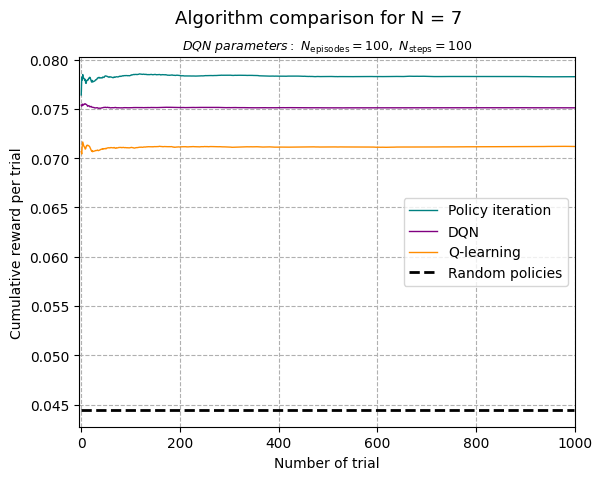

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(42)

N_sim = 100
N_trials = 1000

# run simulations
sims1 = run_simulations(policy_large, possible_states, rewards, probabilities, 0.01, N_trials, N_sim)
sims2 = run_simulations(policy_large_Q, possible_states, rewards, probabilities, 0.01, N_trials, N_sim)
sims3 = run_simulations(DQN_policy, possible_states, rewards, probabilities, 0.01, N_trials, N_sim)

# plot results
plt.plot(sims1, color='teal', linewidth=1, label='Policy iteration')
plt.plot(sims2, color='darkorange', linewidth=1, label='Q-learning')
plt.plot(sims3, color='purple', linewidth=1, label='DQN')
plt.plot(mean_result, linewidth=2, linestyle='--', color='black', label="Random policies")

plt.xlabel('Number of trial')
plt.ylabel('Cumulative reward per trial')
plt.suptitle(f'Algorithm comparison for N = 7', fontsize=13)
plt.title(r'$DQN \ parameters:\ N_{\mathrm{episodes}}=100,\ N_{\mathrm{steps}}=100$', fontsize=9)
plt.legend(loc='center right')
plt.grid(True, linestyle='--')
plt.xlim((-5, 1000))
# plt.ylim((0.069, 0.079))
plt.show()

In [ ]:
diff = sims1[999]-sims3[999]
percent = (sims3[999]/sims1[999])*100
print(f'DQN mean cumulative reward per trial is {diff:4f} less than P.I.')
print(f'DQN mean cumulative reward per trial is {percent:.2f}% that of P.I.')

DQN mean cumulative reward per trial is 0.003156 less than P.I.
DQN mean cumulative reward per trial is 95.97% that of P.I.
